In [29]:
!pip install psycopg2 requests pandas numpy scikit-learn matplotlib joblib Flask waitress

In [1]:
import psycopg2
table_ver = 3
# Connect to PostgreSQL
conn = psycopg2.connect(
    host="localhost",
    database="mydatabase",
    user="myuser",
    password="mypassword"
)
cur = conn.cursor()

Test train a simple ML Model for 5 years mark Model to ensure data processing pipeline is right.  
Also evaluate the importance of each feature quickly using RandomForestRegressor

C:\Users\guang\AppData\Local\Temp\ipykernel_5552\3650638222.py:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


Price - Mean: 1009819.87, Std: 226618.60
Root Mean Squared Error (Unnormalized): 116658.9876820068
R-squared Score: 0.7038430400426381

Feature Importance:
                      feature  importance
3                        area    0.716224
2  months_since_commence_date    0.195832
1  months_since_contract_date    0.068727
4                 floor_range    0.019217
0              market_segment    0.000000


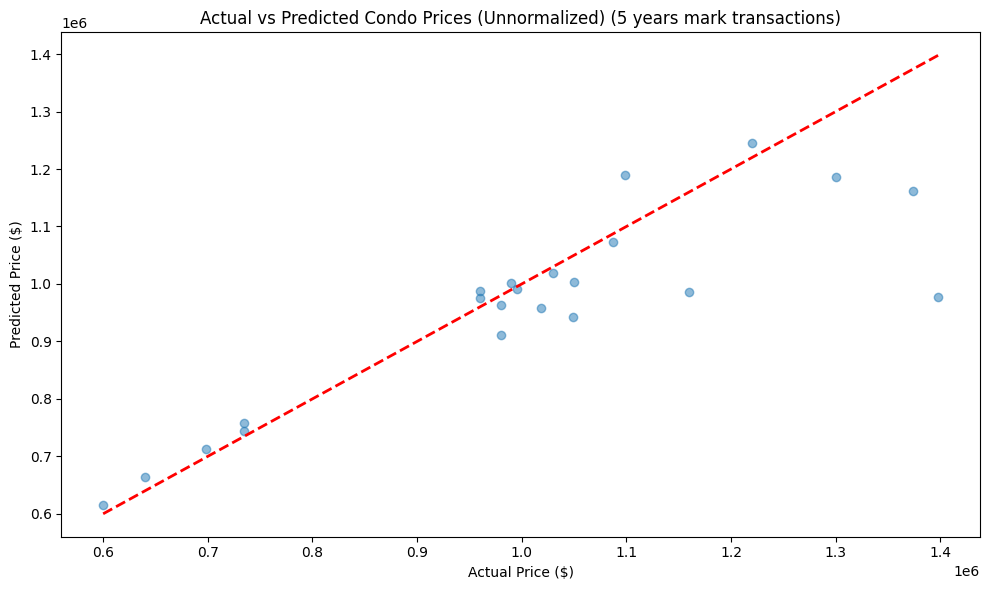

In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# 1. Fetch data from the database
query = f"""
SELECT market_segment, months_since_contract_date, months_since_commence_date, 
       area, price, floor_range
FROM transactions_v{table_ver}
"""
df = pd.read_sql_query(query, conn)

# 2. Preprocess the data
# Create separate LabelEncoders for each categorical variable
le_market_segment = LabelEncoder()
le_floor_range = LabelEncoder()

# Fit and transform each categorical column
df['market_segment'] = le_market_segment.fit_transform(df['market_segment'])
df['floor_range'] = le_floor_range.fit_transform(df['floor_range'])

# Engineer new feature
# df['age_of_property_at_transaction_date'] = df['months_since_commence_date'] - df['months_since_contract_date']


# 2. Preprocess the data
# Calculate mean and std for 'price'
price_mean, price_std = df['price'].mean(), df['price'].std()
print(f"Price - Mean: {price_mean:.2f}, Std: {price_std:.2f}")

# Normalize 'price'
df['price_normalized'] = (df['price'] - price_mean) / price_std

# Split features and target
X = df.drop(['price', 'price_normalized'], axis=1)
y = df['price_normalized']

# 3. Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Train the model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# 5. Make predictions
y_pred_normalized = rf_model.predict(X_test)

# Denormalize predictions and actual values
y_pred = y_pred_normalized * price_std + price_mean
y_test_denormalized = y_test * price_std + price_mean

# 6. Evaluate the model
mse = mean_squared_error(y_test_denormalized, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_denormalized, y_pred)


print(f"Root Mean Squared Error (Unnormalized): {rmse}")
print(f"R-squared Score: {r2}")

# 7. Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

# 8. Visualize predictions vs actual (Unnormalized)
plt.figure(figsize=(10, 6))
plt.scatter(y_test_denormalized, y_pred, alpha=0.5)
plt.plot([y_test_denormalized.min(), y_test_denormalized.max()], 
         [y_test_denormalized.min(), y_test_denormalized.max()], 'r--', lw=2)
plt.xlabel("Actual Price ($)")
plt.ylabel("Predicted Price ($)")
plt.title("Actual vs Predicted Condo Prices (Unnormalized) (5 years mark transactions)")
plt.tight_layout()
plt.show()



In [3]:
df

,market_segment,months_since_contract_date,months_since_commence_date,area,price,floor_range,price_normalized
0,0,44,116,91,980000,1,-0.131586
1,0,42,116,81,860000,0,-0.661110
2,0,37,116,67,765000,0,-1.080317
3,0,37,116,95,1088000,1,0.344986
4,0,37,116,91,960000,0,-0.219840
...,...,...,...,...,...,...,...
101,0,38,128,99,1012000,0,0.009620
102,0,40,128,103,1088000,3,0.344986
103,0,43,128,71,765000,2,-1.080317
104,0,41,128,70,780000,3,-1.014126


Define list of models, automate fine-tunning by GridSearch for 5 years mark model

Best model: {'regressor': SVR(), 'regressor__C': 1.0, 'regressor__kernel': 'linear'}
Root Mean Squared Error (Unnormalized): $97860.81
R-squared Score: 0.7916


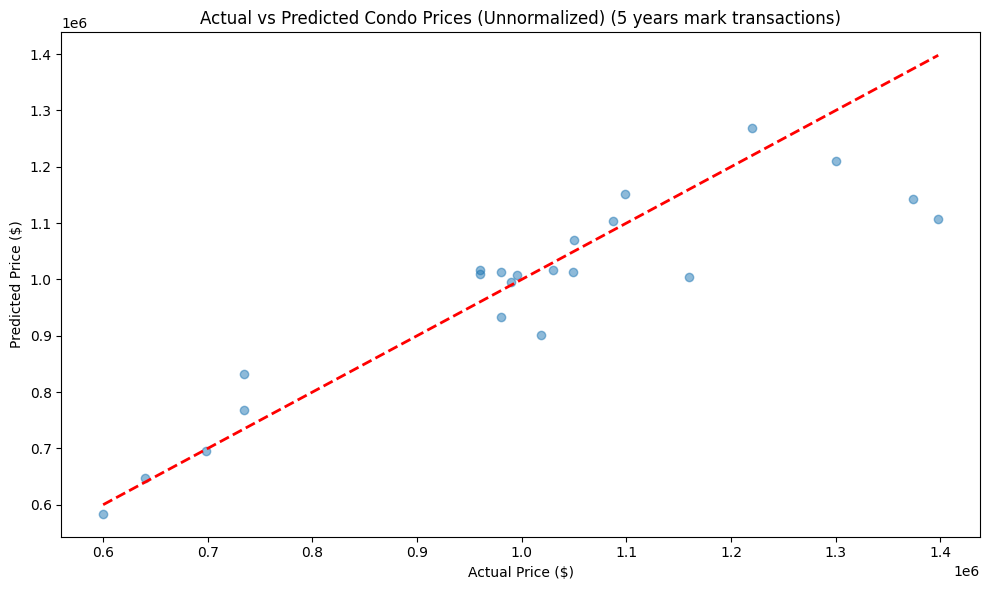

Means of features: [  0.          39.54761905 120.14285714  91.3452381    1.20238095]
Standard deviations of features: [ 1.         10.18566308 13.542827   17.79010831  1.17290606]
Best model and normalization parameters saved (5 years mark transactions)


In [31]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import joblib



# Create a pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', RandomForestRegressor())
])

# Define the models and their hyperparameters to search
param_grid = [
    {
        'regressor': [RandomForestRegressor()],
        'regressor__n_estimators': [50, 100, 200],
        'regressor__max_depth': [None, 10, 20, 30],
        'regressor__min_samples_split': [2, 5, 10],
        'regressor__min_samples_leaf': [1, 2, 4]
    },
    {
        'regressor': [ElasticNet()],
        'regressor__alpha': [0.1, 1.0, 10.0],
        'regressor__l1_ratio': [0.1, 0.5, 0.9]
    },
    {
        'regressor': [SVR()],
        'regressor__C': [0.1, 1.0, 10.0],
        'regressor__kernel': ['rbf', 'linear']
    }
]

# Perform grid search
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_

# Make predictions
y_pred_normalized = best_model.predict(X_test)

# Denormalize predictions and actual values
y_pred = y_pred_normalized * price_std + price_mean
y_test_denormalized = y_test * price_std + price_mean

# Evaluate the model
mse = mean_squared_error(y_test_denormalized, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_denormalized, y_pred)

print(f"Best model: {grid_search.best_params_}")
print(f"Root Mean Squared Error (Unnormalized): ${rmse:.2f}")
print(f"R-squared Score: {r2:.4f}")

# Feature importance (if the best model is RandomForestRegressor)
if isinstance(best_model.named_steps['regressor'], RandomForestRegressor):
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': best_model.named_steps['regressor'].feature_importances_
    }).sort_values('importance', ascending=False)
    print("\nFeature Importance:")
    print(feature_importance)

    # Visualize feature importance
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance['feature'], feature_importance['importance'], color='skyblue')
    plt.xlabel("Importance")
    plt.title("Feature Importance")
    plt.show()


# 8. Visualize predictions vs actual (Unnormalized)
plt.figure(figsize=(10, 6))
plt.scatter(y_test_denormalized, y_pred, alpha=0.5)
plt.plot([y_test_denormalized.min(), y_test_denormalized.max()], 
         [y_test_denormalized.min(), y_test_denormalized.max()], 'r--', lw=2)
plt.xlabel("Actual Price ($)")
plt.ylabel("Predicted Price ($)")
plt.title("Actual vs Predicted Condo Prices (Unnormalized) (5 years mark transactions)")
plt.tight_layout()
plt.show()

# Retrieve the scaler from the best pipeline
scaler = best_model.named_steps['scaler']
# Get the mean and standard deviation
means = scaler.mean_
stds = scaler.scale_

print("Means of features:", means)
print("Standard deviations of features:", stds)

market_segment_mean = means[0]
market_segment_std = stds[0]
months_since_contract_date_mean = means[1]
months_since_contract_date_std = stds[1]
months_since_commence_date_mean = means[2]
months_since_commence_date_std = stds[2]
area_mean = means[3]
area_std = stds[3]
floor_range_mean = means[4]
floor_range_std = stds[4]

# Save the best model
joblib.dump(best_model, 'best_condo_price_predictor.joblib')
joblib.dump(le_market_segment, 'le_market_segment.joblib')
joblib.dump(le_floor_range, 'le_floor_range.joblib')
joblib.dump((price_mean, price_std), 'normalization_params.joblib')
print("Best model and normalization parameters saved (5 years mark transactions)")


Test inference with a fake data

In [43]:
 # Load the saved LabelEncoders
le_market_segment = joblib.load('le_market_segment.joblib')
le_floor_range = joblib.load('le_floor_range.joblib')

# Print valid attributes of the label encoders
print("Market Segment Classes:", le_market_segment.classes_)
print("Floor Range Classes:", le_floor_range.classes_)


# Load models and params
model = joblib.load('best_condo_price_predictor.joblib')
price_mean, price_std = joblib.load('normalization_params.joblib')
scaler = model.named_steps['scaler']
# Get the mean and standard deviation
means = scaler.mean_
stds = scaler.scale_
print("X Means of features:", means)
print("X Standard deviations of features:", stds)
print("Price Mean:", price_mean)
print("Price Std:", price_std)


def prepare_data_for_inference(market_segment, months_since_contract_date, months_since_commence_date, 
                               area, floor_range):
    #normalize data

    # Create a dictionary with the input data
    data = {
        'market_segment': [le_market_segment.transform([market_segment])[0]],
        'months_since_contract_date': [months_since_contract_date],
        'months_since_commence_date': [months_since_commence_date],
        'area': [area],
        'floor_range': [le_floor_range.transform([floor_range])[0]],
    }
    
    # Convert to DataFrame
    df = pd.DataFrame(data)
    
    # Add the engineered feature
    # df['age_of_property_at_transaction_date'] = df['months_since_commence_date'] - df['months_since_contract_date']
    
    return df

# Example usage for inference, change fake data values to test
new_data = prepare_data_for_inference(market_segment='OCR', 
                                      months_since_contract_date=55, 
                                      months_since_commence_date=120, 
                                      area=95, 
                                      floor_range='11-15')

normalized_predicted_price = model.predict(new_data)
predicted_price = normalized_predicted_price * price_std + price_mean
print(f"Predicted price: ${predicted_price[0]:,.2f}")

Market Segment Classes: ['OCR']
Floor Range Classes: ['01-05' '06-10' '11-15' '16-20' '21-25']
X Means of features: [  0.          39.54761905 120.14285714  91.3452381    1.20238095]
X Standard deviations of features: [ 1.         10.18566308 13.542827   17.79010831  1.17290606]
Price Mean: 1009819.8679245283
Price Std: 226618.5974494665
Predicted price: $1,015,185.99


Test train a simple ML Model for 10 years mark Model to ensure data processing pipeline is right.  
Also evaluate the importance of each feature quickly using RandomForestRegressor

C:\Users\guang\AppData\Local\Temp\ipykernel_5552\3029283476.py:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


Price - Mean: 1290051.34, Std: 287490.22
Root Mean Squared Error (Unnormalized): 89599.8036975767
R-squared Score: 0.9034086466798812

Feature Importance:
                      feature  importance
3                        area    0.635658
1  months_since_contract_date    0.319644
4                 floor_range    0.025940
2  months_since_commence_date    0.018758
0              market_segment    0.000000


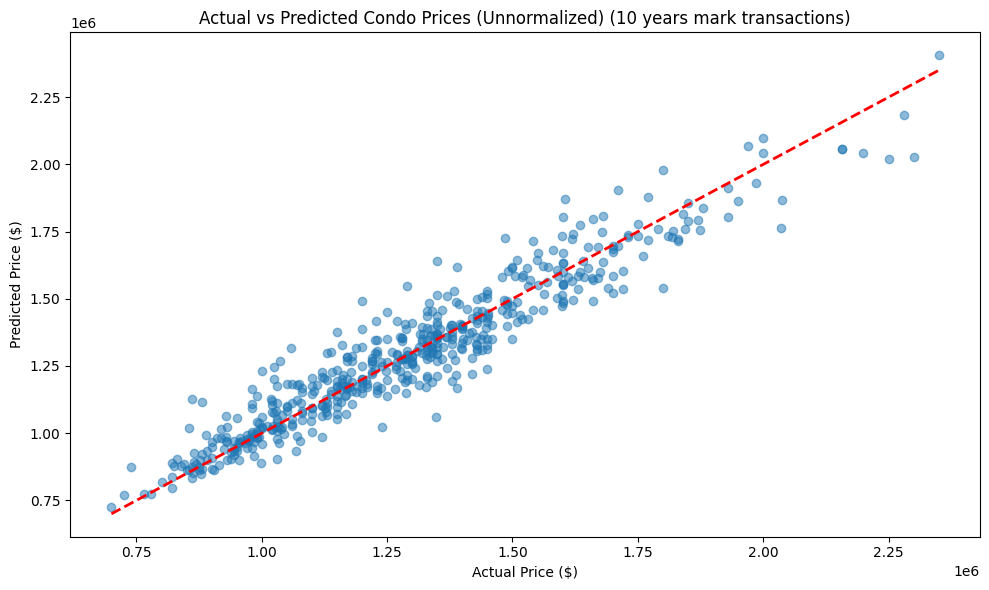

In [37]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# 1. Fetch data from the database
query = f"""
SELECT market_segment, months_since_contract_date, months_since_commence_date, 
       area, price, floor_range
FROM transactions_v{table_ver + 1}
"""
df = pd.read_sql_query(query, conn)

# 2. Preprocess the data
# Create separate LabelEncoders for each categorical variable
le_market_segment = LabelEncoder()
le_floor_range = LabelEncoder()

# Fit and transform each categorical column
df['market_segment'] = le_market_segment.fit_transform(df['market_segment'])
df['floor_range'] = le_floor_range.fit_transform(df['floor_range'])

# Engineer new feature
# df['age_of_property_at_transaction_date'] = df['months_since_commence_date'] - df['months_since_contract_date']


# 2. Preprocess the data
# Calculate mean and std for 'price'
price_mean, price_std = df['price'].mean(), df['price'].std()
print(f"Price - Mean: {price_mean:.2f}, Std: {price_std:.2f}")

# Normalize 'price'
df['price_normalized'] = (df['price'] - price_mean) / price_std

# Split features and target
X = df.drop(['price', 'price_normalized'], axis=1)
y = df['price_normalized']

# 3. Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Train the model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# 5. Make predictions
y_pred_normalized = rf_model.predict(X_test)

# Denormalize predictions and actual values
y_pred = y_pred_normalized * price_std + price_mean
y_test_denormalized = y_test * price_std + price_mean

# 6. Evaluate the model
mse = mean_squared_error(y_test_denormalized, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_denormalized, y_pred)


print(f"Root Mean Squared Error (Unnormalized): {rmse}")
print(f"R-squared Score: {r2}")

# 7. Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

# 8. Visualize predictions vs actual (Unnormalized)
plt.figure(figsize=(10, 6))
plt.scatter(y_test_denormalized, y_pred, alpha=0.5)
plt.plot([y_test_denormalized.min(), y_test_denormalized.max()], 
         [y_test_denormalized.min(), y_test_denormalized.max()], 'r--', lw=2)
plt.xlabel("Actual Price ($)")
plt.ylabel("Predicted Price ($)")
plt.title("Actual vs Predicted Condo Prices (Unnormalized) (10 years mark transactions)")


plt.tight_layout()
plt.show()




In [38]:
df

,market_segment,months_since_contract_date,months_since_commence_date,area,price,floor_range,price_normalized
0,0,55,176,125,1200000,2,-0.313233
1,0,52,176,100,930000,1,-1.252395
2,0,50,176,100,925000,1,-1.269787
3,0,56,176,100,980000,2,-1.078476
4,0,51,176,92,868000,1,-1.468055
...,...,...,...,...,...,...,...
2649,0,6,128,103,1450000,0,0.556362
2650,0,3,128,99,1455000,1,0.573754
2651,0,4,128,87,1160000,0,-0.452368
2652,0,3,128,103,1505000,0,0.747673


Best model: {'regressor': RandomForestRegressor(), 'regressor__max_depth': 30, 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 5, 'regressor__n_estimators': 200}
Root Mean Squared Error (Unnormalized): $89046.92
R-squared Score: 0.9046

Feature Importance:
                      feature  importance
3                        area    0.641283
1  months_since_contract_date    0.318541
4                 floor_range    0.023951
2  months_since_commence_date    0.016226
0              market_segment    0.000000


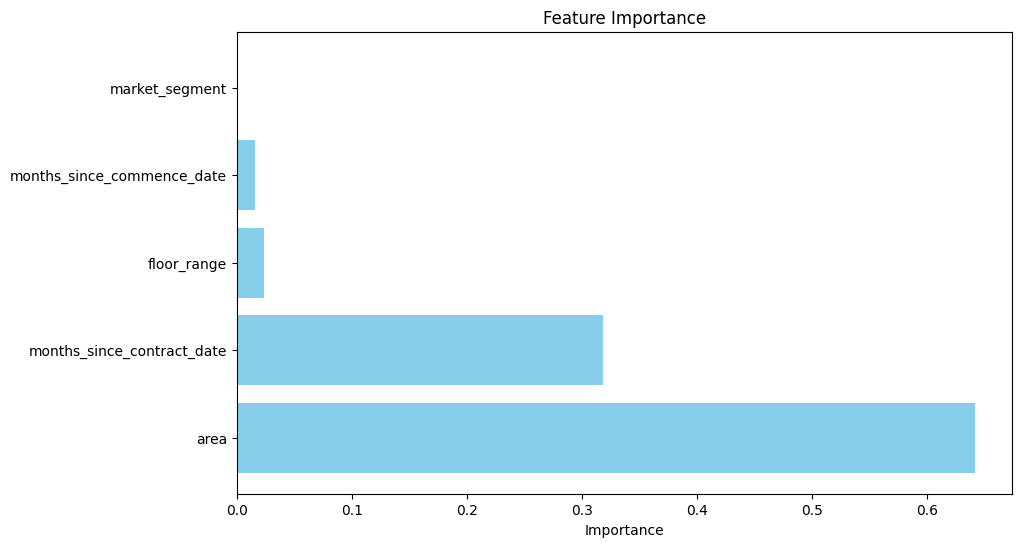

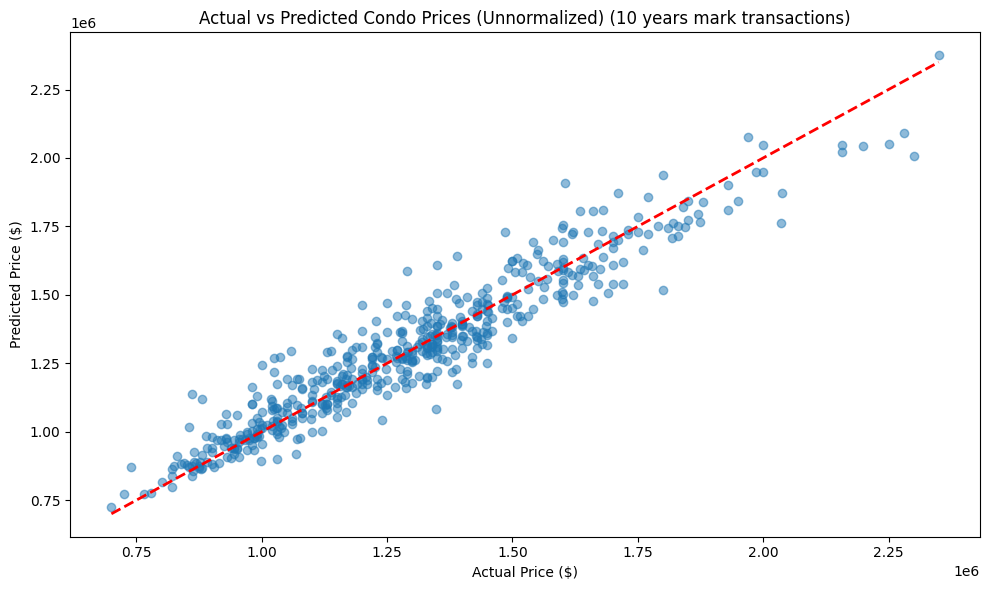

Best model and normalization parameters saved


In [39]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import joblib


# Create a pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', RandomForestRegressor())
])

# Define the models and their hyperparameters to search
param_grid = [
    {
        'regressor': [RandomForestRegressor()],
        'regressor__n_estimators': [50, 100, 200],
        'regressor__max_depth': [None, 10, 20, 30],
        'regressor__min_samples_split': [2, 5, 10],
        'regressor__min_samples_leaf': [1, 2, 4]
    },
    {
        'regressor': [ElasticNet()],
        'regressor__alpha': [0.1, 1.0, 10.0],
        'regressor__l1_ratio': [0.1, 0.5, 0.9]
    },
    {
        'regressor': [SVR()],
        'regressor__C': [0.1, 1.0, 10.0],
        'regressor__kernel': ['rbf', 'linear']
    }
]

# Perform grid search
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_

# Make predictions
y_pred_normalized = best_model.predict(X_test)

# Denormalize predictions and actual values
y_pred = y_pred_normalized * price_std + price_mean
y_test_denormalized = y_test * price_std + price_mean

# Evaluate the model
mse = mean_squared_error(y_test_denormalized, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_denormalized, y_pred)

print(f"Best model: {grid_search.best_params_}")
print(f"Root Mean Squared Error (Unnormalized): ${rmse:.2f}")
print(f"R-squared Score: {r2:.4f}")

# Feature importance (if the best model is RandomForestRegressor)
if isinstance(best_model.named_steps['regressor'], RandomForestRegressor):
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': best_model.named_steps['regressor'].feature_importances_
    }).sort_values('importance', ascending=False)
    print("\nFeature Importance:")
    print(feature_importance)

    # Visualize feature importance
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance['feature'], feature_importance['importance'], color='skyblue')
    plt.xlabel("Importance")
    plt.title("Feature Importance")
    plt.show()


# 8. Visualize predictions vs actual (Unnormalized)
plt.figure(figsize=(10, 6))
plt.scatter(y_test_denormalized, y_pred, alpha=0.5)
plt.plot([y_test_denormalized.min(), y_test_denormalized.max()], 
         [y_test_denormalized.min(), y_test_denormalized.max()], 'r--', lw=2)
plt.xlabel("Actual Price ($)")
plt.ylabel("Predicted Price ($)")
plt.title("Actual vs Predicted Condo Prices (Unnormalized) (10 years mark transactions)")
plt.tight_layout()
plt.show()

# Save the best model
joblib.dump(best_model, 'best_condo_price_predictor_10yrs.joblib')
joblib.dump(le_market_segment, 'le_market_segment_10yrs.joblib')
joblib.dump(le_floor_range, 'le_floor_range_10yrs.joblib')
joblib.dump((price_mean, price_std), 'normalization_params_10yrs.joblib')
print("Best model and normalization parameters saved")

Test Inference with fake data for 10 years mark model

In [42]:
 # Load the saved LabelEncoders
le_market_segment = joblib.load('le_market_segment_10yrs.joblib')
le_floor_range = joblib.load('le_floor_range_10yrs.joblib')

# Print valid attributes of the label encoders
print("Market Segment Classes:", le_market_segment.classes_)
print("Floor Range Classes:", le_floor_range.classes_)

# Load models and params
model = joblib.load('best_condo_price_predictor_10yrs.joblib')
scaler = model.named_steps['scaler']
# Get the mean and standard deviation
means = scaler.mean_
stds = scaler.scale_
print("X Means of features:", means)
print("X Standard deviations of features:", stds)


price_mean, price_std = joblib.load('normalization_params_10yrs.joblib')

print("Price Mean:", price_mean)
print("Price Std:", price_std)
    
def prepare_data_for_inference(market_segment, months_since_contract_date, months_since_commence_date, 
                               area, floor_range):
    
    # Create a dictionary with the input data
    data = {
        'market_segment': [le_market_segment.transform([market_segment])[0]],
        'months_since_contract_date': [months_since_contract_date],
        'months_since_commence_date': [months_since_commence_date],
        'area': [area],
        'floor_range': [le_floor_range.transform([floor_range])[0]],
    }
    
    # Convert to DataFrame
    df = pd.DataFrame(data)
    
    # Add the engineered feature
    # df['age_of_property_at_transaction_date'] = df['months_since_commence_date'] - df['months_since_contract_date']
    
    return df

# Example usage for inference, change fake data values to test
new_data = prepare_data_for_inference(market_segment='OCR', 
                                      months_since_contract_date=55, 
                                      months_since_commence_date=120, 
                                      area=95, 
                                      floor_range='11-15')

normalized_predicted_price = model.predict(new_data)
predicted_price = normalized_predicted_price * price_std + price_mean
print(f"Predicted price: ${predicted_price[0]:,.2f}")

Market Segment Classes: ['OCR']
Floor Range Classes: ['01-05' '06-10' '11-15' '16-20' '21-25']
X Means of features: [  0.          23.60244936 154.39095619 104.1954781    1.1163448 ]
X Standard deviations of features: [ 1.         15.45282075 15.63658624 21.42961484  0.98845499]
Price Mean: 1290051.3428786737
Price Std: 287490.2154137477
Predicted price: $885,950.12


Test Flask API App 

In [46]:
from flask import Flask, request, jsonify
import joblib
import pandas as pd

app = Flask(__name__)

# Load the saved LabelEncoders and model for 5 years mark model
le_market_segment = joblib.load('le_market_segment.joblib')
le_floor_range = joblib.load('le_floor_range.joblib')
model = joblib.load('best_condo_price_predictor.joblib')
scaler = model.named_steps['scaler']
# Get the mean and standard deviation
means = scaler.mean_
stds = scaler.scale_
print("X Means of features:", means)
print("X Standard deviations of features:", stds)

# Load the saved LabelEncoders and model for 10 years mark model
le_market_segment_10yrs = joblib.load('le_market_segment_10yrs.joblib')
le_floor_range_10yrs = joblib.load('le_floor_range_10yrs.joblib')
model_10yrs = joblib.load('best_condo_price_predictor_10yrs.joblib')
scaler_10yrs = model_10yrs.named_steps['scaler']
# Get the mean and standard deviation
means_10yrs = scaler_10yrs.mean_
stds_10yrs = scaler_10yrs.scale_
print("X Means of features (10 years mark model):", means_10yrs)
print("X Standard deviations of features (10 years mark model):", stds_10yrs)

price_mean, price_std = joblib.load('normalization_params.joblib')
price_mean_10yrs, price_std_10yrs = joblib.load('normalization_params_10yrs.joblib')

def prepare_data_for_inference(market_segment, months_since_contract_date, months_since_commence_date, 
                               area, floor_range):
    data = {
        'market_segment': [le_market_segment.transform([market_segment])[0]],
        'months_since_contract_date': [months_since_contract_date],
        'months_since_commence_date': [months_since_commence_date],
        'area': [area],
        'floor_range': [le_floor_range.transform([floor_range])[0]],
    }
    return pd.DataFrame(data)

@app.route('/predict', methods=['POST'])
def predict():
    # Get JSON data from request
    data = request.json
    market_segment = data['market_segment']
    months_since_contract_date = data['months_since_contract_date']
    months_since_commence_date = data['months_since_commence_date']
    area = data['area']
    floor_range = data['floor_range']
    
    # Prepare data for inference
    new_data = prepare_data_for_inference(market_segment, months_since_contract_date, 
                                          months_since_commence_date, area, floor_range)
    
    # Make prediction
    if months_since_commence_date - months_since_contract_date  < 119:
        print(f"Using 5 years mark model inference")
        normalized_predicted_price = model.predict(new_data)
        predicted_price = normalized_predicted_price * price_std + price_mean
    else:
        print(f"Using 10 years mark model inference")
        normalized_predicted_price = model_10yrs.predict(new_data)
        predicted_price = normalized_predicted_price * price_std_10yrs + price_mean_10yrs
    
    return jsonify({'predicted_price': predicted_price[0]})

if __name__ == '__main__':
    app.run()

X Means of features: [  0.          39.54761905 120.14285714  91.3452381    1.20238095]
X Standard deviations of features: [ 1.         10.18566308 13.542827   17.79010831  1.17290606]
X Means of features (10 years mark model): [  0.          23.60244936 154.39095619 104.1954781    1.1163448 ]
X Standard deviations of features (10 years mark model): [ 1.         15.45282075 15.63658624 21.42961484  0.98845499]
 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [15/Sep/2024 06:43:37] "POST /predict HTTP/1.1" 200 -


Using 10 years mark model inference


127.0.0.1 - - [15/Sep/2024 06:44:15] "POST /predict HTTP/1.1" 200 -


Using 5 years mark model inference


127.0.0.1 - - [15/Sep/2024 06:44:37] "POST /predict HTTP/1.1" 200 -


Using 10 years mark model inference


127.0.0.1 - - [15/Sep/2024 06:45:59] "POST /predict HTTP/1.1" 200 -


Using 5 years mark model inference


127.0.0.1 - - [15/Sep/2024 06:47:28] "POST /predict HTTP/1.1" 200 -


Using 10 years mark model inference


127.0.0.1 - - [15/Sep/2024 06:47:50] "POST /predict HTTP/1.1" 200 -


Using 5 years mark model inference


In [52]:
import requests
# Sample data for the request
data = {
    "market_segment": "OCR",
    "months_since_contract_date": 10,
    "months_since_commence_date": 130,
    "area": 130,
    "floor_range": "11-15"
}

# Make a POST request to the /predict endpoint
response = requests.post('http://127.0.0.1:5000/predict', json=data)

# Print the response
print(response.json())

{'predicted_price': 1663513.4416631465}
